_Author: Dana Chermesh for Perl Street_
# Hotel conversion to a Co-living project, Greenwich Village, NYC
## _27W 11th St, NY, NY_
### Objective:
The goal of this project is to make first pass revenue and risk projections of a hotel located in Greenwich Village, NYC, being converted into 77 units co-living residential housing, using different public data sources. Assume that there is no construction risk. 

### Project Highlights:
- Unique NYC location in the heart of Greenwich Village steps away from Union Square, the West Village, the East Village, Soho and the Lower East Side
- Almost built to suit product with a kitchenette per every 7 bedrooms and large communal space on the basement level
- NYC has seen a tremendous rise in the number of co-living building but this is uniquely positioned within the city 

### Gross Area:
Approximately **24,000 SQFT**

### # of Units:
**77 Co-Living Units**

### Listing Date:
August 1st 2018

### Communal Space Rations:
1. 1 Small Kitchenette per 7 bedrooms
2. 1 Bathroom per every 3.5 bedrooms
3. 1 full size kitchen per 77 bedrooms
4. 1 Lounge per 25 bedrooms
5. 1 Open Space per 77 bedrooms
6. 1 Laundry area per 77 bedrooms

----

# Analysis steps:
## 1. Determine the first rent to be asked for a bedroom in 27 W 11 street coliving project:
1.1 Assess the size of a bedroom / a basic unit (== 7 bedrooms) in the project <br>
1.2 _Time series analysis:_ Observe the change + trend in the comparable housing type for rental market in Greenwich Village neighbourhood <br>
1.3 Build a _housing-coliving rent ratio_ based on _office-coworking rent ratio_
## 2. _Multivariate linear regression analysis:_ 
2.1 build a model to predict rent change <br>
2.2 compute p-values, coefficients and feature importance <br>
## 3. Predict asking rent + vacancies over the next 15 years


# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as pl

import json
import requests 
import urllib
from pandas.tools.plotting import scatter_matrix

# OLS / ML assignments
import scipy as sp
# from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, log_loss
# from scipy.spatial.distance import cdist, pdist
from scipy.cluster.vq import kmeans2, whiten
from sklearn import preprocessing
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics, cross_validation
# from sklearn import ensemble
from sklearn.model_selection import train_test_split
# from sklearn import svm
from sklearn import linear_model
# from sklearn.linear_model import LogisticRegression, RidgeClassifierCV

import seaborn as sns
sns.set_style('whitegrid')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1.1 Assess the size of a bedroom / a basic unit (== 7 bedrooms) in the project

Given info + Assumptions: 
-	**24,000 sf** == **4000 sf * 6 stories** _(not including basement)_
-	A **_basic unit_** includes **7 bedrooms, 2 bathrooms, 1 small kitchenette**
- All basic units are identical.
-	**2 basic units in each story** for floors 2-6, **Lounge + 1 basic unit** in floor 1.
-	**Basement**: Open space, Full-size Kitchen, Laundry
-	Public area that is not included in the basic unit (stairs + elevators, technical systems, etc) is about **10% of a floor** >> leaving **3,600 sf for 2 basic units, 1,800 sf each**.
-	Each bedroom’s size is considered as the bedroom area + its share in the unit’s amenities, meaning the 2 bathrooms + kitchenette.


## Result: 
A **basic unit is _1,800 sf_**, each **bedroom is considered to be _255 sf_**. This size is similar to other coliving bedrooms in NYC, although the _ratio of bedroom-bathroom_ and _bedroom-kitchen_ is worse than most others:  **2 bathroom for every 7 bedrooms** compared to **private bathrooms to 2 bathrooms for every 3 bedrooms** (examples: [Ollie floor plans](https://altalic.com/wp-content/uploads/2018/08/ALTA-by-Ollie-804.png), [COMMON floor plans](http://cdn.brownstoner.com/wp-content/uploads/2015/10/Common-1162-Cellar1st-2nd-Floor-Construction-Plans-e1445273623967.jpg)). <br>**This might negatively affect the demand for the bedrooms and should be calculated into the risks and revenues prediction**.

![coliving_unit/](coliving_unit.png)

## Picture.1: Project Mix (left) and a suggested co-living basic unit of 7 bedrooms, 2 bathrooms and a kitchenette (right)
** _The plan is based on different plans of current co-housing in NYC, measurements are not accurate to the SF calculation above._

----
# 1. Data Acquisition
Data retrieved for this analysis were divided to three objectives:
1. _**Assess the current rent to be asked for a bedroom in the co-living project**_
2. hgfhgf
3. hgfhgf

## 1.1 Street Easy data for Multifamily rentals in Greenwich Village, 1-br and studios

### Approach: 
Analyse the neighborhood housing market (rentals only) for multifamily, **1-br and studios apartments only**, as the classic housing type equivalent to a co-housing bedroom.

### Scope and Assumptions:
-	Street Easy is a reliable proxy for assessing housing market condition + demand.
-	Analysing the condition + trends of the specific neighborhood only.
-	The total inventories of 1-br and studios will be the base for weightening the two types median rents in order to assess an equivalent dwelling type for a co-living bedroom
-	Lacking longitudinal data on co-housing, the ratio of Office VS co-working equivalent space will be used as a proxy for assessing the rent ratio between co-living bedroom and its equivalent classic housing type.

### Data Source:
_**[Street Easy Data](https://streeteasy.com/blog/download-data/)**_. Data were aquired for multifamily rentals of 1-br and studios for Greenwich Village neighborhood. 

For direct download of zipped files:

   - [Inventory 1br](https://s3.amazonaws.com/streeteasy-market-data-api/data_repository/G1_rentalInventory_OneBd.zip)
   - [Inventory studio](https://s3.amazonaws.com/streeteasy-market-data-api/data_repository/F1_rentalInventory_Studio.zip)
   - [Median asking rent 1br](https://s3.amazonaws.com/streeteasy-market-data-api/data_repository/G2_medianAskingRent_OneBd.zip)
   - [Median asking rent studio](https://s3.amazonaws.com/streeteasy-market-data-api/data_repository/F2_medianAskingRent_Studio.zip)

In [2]:
DATA = "/../Users/danachermesh/Desktop/DataProjects/ColivingNYC/data"

In [3]:
# inventory 1br
inventory_1br = pd.read_csv(DATA + "/G1_rentalInventory_OneBd.csv").fillna(0)
inventory_1br = inventory_1br[inventory_1br["Area"] == "Greenwich Village"]

inventory_1br = inventory_1br.set_index("Area")
inventory_1br = inventory_1br.iloc[:,2:]
inventory_1br = inventory_1br.astype(int)
inventory_1br = inventory_1br.rename({'Greenwich Village': 'inv_1BR'})

# inventory studio
inventory_st = pd.read_csv(DATA + "/F1_rentalInventory_Studio.csv").fillna(0)
inventory_st = inventory_st[inventory_st["Area"] == "Greenwich Village"]

inventory_st = inventory_st.set_index("Area")
inventory_st = inventory_st.iloc[:,2:]
inventory_st = inventory_st.astype(int)
inventory_st = inventory_st.rename({'Greenwich Village': 'inv_Studio'})

# Median rent 1br
MedianRent_1br = pd.read_csv(DATA + "/G2_medianAskingRent_OneBd.csv").fillna(0)
MedianRent_1br = MedianRent_1br[MedianRent_1br["Area"] == "Greenwich Village"]

MedianRent_1br = MedianRent_1br.set_index("Area")
MedianRent_1br = MedianRent_1br.iloc[:,2:]
MedianRent_1br = MedianRent_1br.astype(int)
MedianRent_1br = MedianRent_1br.rename({'Greenwich Village': 'MedRent_1BR'})

# Median rent studio
MedianRent_studio = pd.read_csv(DATA + "/F2_medianAskingRent_Studio.csv").fillna(0)
MedianRent_studio = MedianRent_studio[MedianRent_studio["Area"] == "Greenwich Village"]

MedianRent_studio = MedianRent_studio.set_index("Area")
MedianRent_studio = MedianRent_studio.iloc[:,2:]
MedianRent_studio = MedianRent_studio.astype(int)
MedianRent_studio = MedianRent_studio.rename({'Greenwich Village': 'MedRent_Studio'})

GW_rentals = MedianRent_1br.append([MedianRent_studio, inventory_1br, inventory_st])

print(GW_rentals.shape)
GW_rentals

(4, 102)


,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06
Area,,,,,,,,,,,,,,,,,,,,,
MedRent_1BR,3175,3200,2997,3000,3000,3250,3000,3000,3650,3725,...,3600,3662,3662,3695,3600,3750,3650,3750,3450,3695
MedRent_Studio,2100,2100,2000,2000,2190,2100,2037,2087,2472,2600,...,2725,2750,2687,2600,2646,2615,2697,2750,2700,2685
inv_1BR,164,196,194,214,222,223,188,184,133,136,...,223,228,196,178,189,177,183,213,197,209
inv_Studio,101,111,134,133,162,165,150,136,76,71,...,108,111,108,97,107,94,102,107,112,116


In [4]:
GW_rentals.columns[-1]

'2018-06'

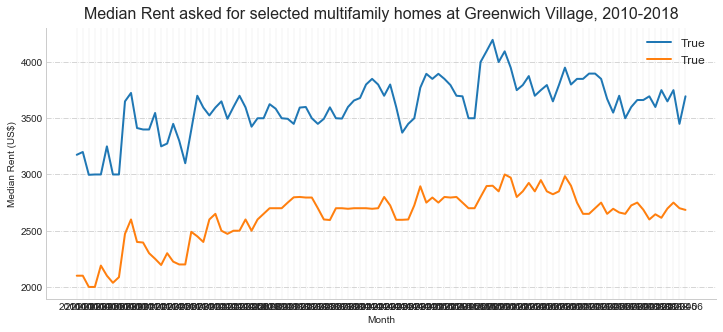

In [5]:
fig = pl.figure(figsize=(12,5))
ax = fig.add_subplot(111)

ax.plot(GW_rentals.T.iloc[:,:2], label=True, lw=2)
ax.set_title("Median Rent asked for selected multifamily homes at Greenwich Village, 2010-2018",
            fontsize=16, y=1.01)
ax.set_ylabel('Median Rent (US$)')
ax.set_xlabel('Month')

ax.grid(axis='y', linestyle='-.')
ax.grid(axis='x', lw=.2);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(fontsize=12)

# DANA EDIT XTICKS
### Fig.1 1BR and Studio rentals at Greenwich Village, Manhattan from 2010/01 to 2018/06;
Both types of multifamily residential rentals are showing similar trends; therefore I will average their prices, weighted by their total inventories, to assess the median rent ansked for the relevant market. This price will be used as a base for the co-living rent asking in the same area.

In [6]:
GV0_1_rent = GW_rentals.T

GV0_1_rent['GV_medRent'] = (GV0_1_rent['MedRent_1BR']*GV0_1_rent['inv_1BR'] + 
                            GV0_1_rent['MedRent_Studio']*GV0_1_rent['inv_Studio']) / \
                            (GV0_1_rent['inv_1BR'] + GV0_1_rent['inv_Studio'])

GV0_1_rent = GV0_1_rent.iloc[:,-1:]
GV0_1_rent = GV0_1_rent.round(0).astype(int)

GV0_1_rent.head()

Area,GV_medRent
2010-01,2765
2010-02,2802
2010-03,2590
2010-04,2617
2010-05,2658


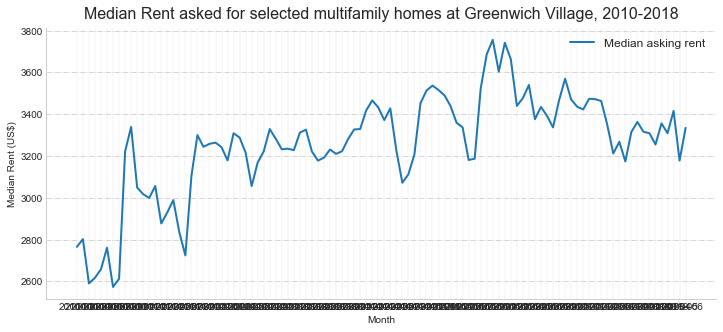

In [7]:
fig = pl.figure(figsize=(12,5))
ax = fig.add_subplot(111)

ax.plot(GV0_1_rent.iloc[:,-1:], label='Median asking rent', lw=2)

ax.set_title("Median Rent asked for selected multifamily homes at Greenwich Village, 2010-2018",
            fontsize=16, y=1.01)
ax.set_ylabel('Median Rent (US$)')
ax.set_xlabel('Month')

ax.grid(axis='y', linestyle='-.');
ax.grid(axis='x', lw=.2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(fontsize=12)

### Fig.2: Median asking rent for multifamily homes at Greenwich Village, Manhattan, NYC, 2010/01-2018/06, studios+1-br only (weighted average)
A trend is shown......
# DANA EXPLAIN MORE

In [8]:
# smoothing + more time series analysis
# what is the trend?
# begin price >> one year ahead (or Aug18?)

## 1.2 Demographics 
Census Data; data of age, income, renters % out of housing units stock / population, population growth.... were obtained for years 2010 (Decennial Census) and for 2016 (ACS 5-years estimates 2012-2016).

In [9]:
# reading in my api key saved in censusAPI.py as
# myAPI = 'XXXXXXXXXXXXXXX'
# request an api key in: https://api.census.gov/data/key_signup.html
from censusAPI import myAPI

In [10]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs5/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [11]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))

affkeys

array(['B17022_029E', 'B07404GPR_004E', 'C23002E_002E', ...,
       'B20005E_037E', 'B24012_045E', 'B17022_049E'], dtype='<U14')

In [12]:
# keyword for POP estimates
totalPop = 'B01003_001E'
income = 'B06011_001E'
bachelor = 'B15003_022E' # age 25 and over
totalHU = 'B25001_001E'
vac_forrent = 'B25004_002E'
vac_rented = 'B25004_003E'
renter = 'B25003_003E'

grossrent_0br = 'B25031_002E'
grossrent_1br = 'B25031_003E'

aff1y['variables'][vac_rented]

{'attributes': 'B25004_003M,B25004_003MA,B25004_003EA',
 'concept': 'VACANCY STATUS',
 'group': 'B25004',
 'label': 'Estimate!!Total!!Rented, not occupied',
 'limit': 0,
 'predicateType': 'int'}

In [13]:
# 2016 data for all census tracts in NYC
data16 = pd.read_json('https://api.census.gov/data/2016/acs/acs5?get='+
                         totalPop + ',' + 
                         income + ',' + 
                         bachelor + ',' +
                         totalHU + ',' +
                         vac_forrent + ',' +
                         vac_rented + ',' +
                         renter + ',' +
                         grossrent_0br + ',' +
                         grossrent_1br +',NAME&for=tract:*&in=state:36'\
                                        '&in=county:061,047,081,085,005')

data16.columns = data16.iloc[0]
data16 = data16.iloc[1:,:-4] # named tracts index is redundant in this case

data16.columns = ['totalPop', 'MedIncome', 'bachelor', 'totalHU', 
                  'vac_forrent', 'vac_rented', 'renter',
                  'grossrent_0br', 'grossrent_1br']

data16 = data16.astype(int)
data16 = data16[(data16 != 0).all(1)]

data16 = data16[data16['grossrent_0br'] > 0]
data16 = data16[data16['grossrent_1br'] > 0].reset_index()\
        .drop('index', axis=1)

print(data16.shape)
data16.head(3)

(327, 9)


,totalPop,MedIncome,bachelor,totalHU,vac_forrent,vac_rented,renter,grossrent_0br,grossrent_1br
0,6056,17848,211,2049,29,34,1665,550,653
1,9131,13258,491,3190,69,17,2497,399,638
2,6021,13915,244,2151,77,30,1841,663,708


## Data wrangling
- rented housing units % out of total housing units
- occupied % out of total housing units
- vacants % out of total housing units
- Average Gross rent for 0br + 1br

In [14]:
data16['bachelor_per'] = data16['bachelor']/data16['totalPop']
data16['rented_per'] = data16['renter']/data16['totalHU']
data16['vacants_rent_per'] = (data16['vac_forrent']+data16['vac_rented']) / data16['totalHU']

data16['Med_GrossRent'] = (data16['grossrent_0br']+data16['grossrent_1br'])/2

data16 = data16.drop(['bachelor', 'vac_forrent', 'vac_rented',
                      'renter', 'grossrent_0br', 'grossrent_1br'],
                       axis=1)

print(data16.shape)
data16.head()

(327, 7)


,totalPop,MedIncome,totalHU,bachelor_per,rented_per,vacants_rent_per,Med_GrossRent
0,6056,17848,2049,0.034841,0.812592,0.030747,601.5
1,9131,13258,3190,0.053773,0.782759,0.026959,518.5
2,6021,13915,2151,0.040525,0.855881,0.049744,685.5
3,5181,18604,1666,0.041112,0.823529,0.013205,1270.0
4,5687,15040,2038,0.036223,0.881256,0.035819,1043.0


-----
# 2. Analysis

No handles with labels found to put in legend.


<Figure size 1440x576 with 0 Axes>

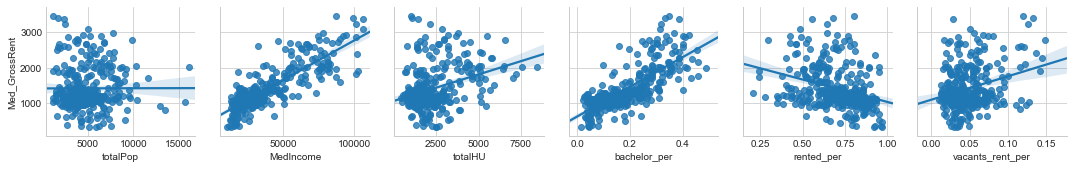

In [15]:
pl.figure(figsize = (20,8))

sns.pairplot(x_vars=data16.columns[:-1], y_vars='Med_GrossRent', 
             data=data16, kind="reg")
sns.set_style("whitegrid")
pl.legend(fontsize=16)

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


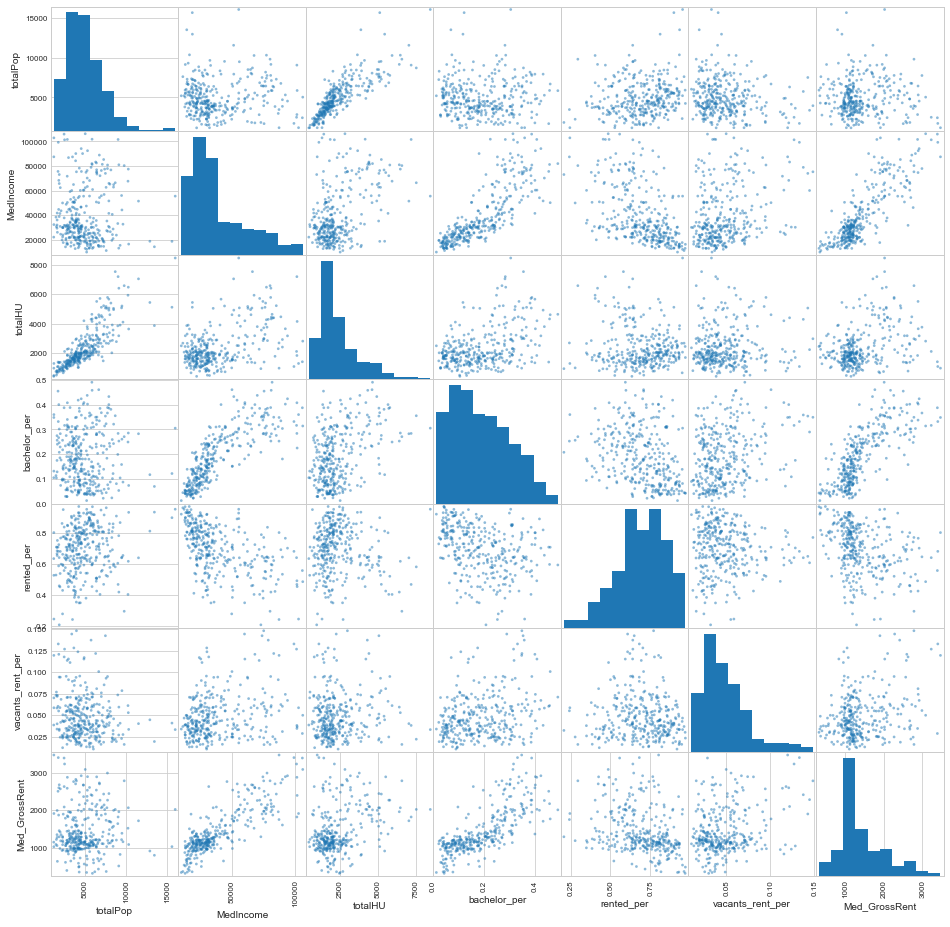

In [95]:
scatter_matrix (data16, s=30, figsize=(16, 16));

### Fig.3 Scatter plot of variables to be used in the multivariate regression
Possible correlation is shown between _median Income_ and Median Gross rent and between % of bachelor's and Median gross rent

# 2. Multivariate Regression Analysis
using census data in order to predict change in median rents. 

In [90]:
# Create X and Y in matrix form then use matrix computation formula to calculate the coefficients
X = np.matrix(data16.iloc[:,:-1])
Y = np.matrix(data16.iloc[:,-1:])
w = (X.T * X).I * X.T * Y
print(w)

[[ 5.60952426e-02]
 [ 2.10545961e-02]
 [-1.38278520e-01]
 [ 1.49334562e+03]
 [ 4.43768650e+02]
 [ 1.12835797e+03]]


In [96]:
# Use statsmodels to regress y over x1 and x2, provide the r-squared and coefficients
lm1 = smf.ols(formula = 'Med_GrossRent ~ totalPop + MedIncome +'\
                        'totalHU + bachelor_per + rented_per + vacants_rent_per', 
                        data = data16).fit()
print('R2 = %f'%lm1.rsquared)
print(lm1.params)

R2 = 0.741061
Intercept             -4.860533
totalPop               0.056324
MedIncome              0.021083
totalHU               -0.138658
bachelor_per        1493.755794
rented_per           448.158821
vacants_rent_per    1133.768323
dtype: float64


## 2.2 create a model to predict Median asked rent, based on census data that returns  parameter of model quality + feature importance rank of the model + features statistical significance. 

In [18]:
X = data16.iloc[:,:-1] # regressors; census demographics + housing data
y = data16.iloc[:,-1:] # target variable; Gross Median Rent

print(X.shape)
print(y.shape)

(327, 6)
(327, 1)


In [20]:
linearReg = linear_model.LinearRegression()
linearReg = linearReg.fit(X, y)
print ("in-sample score of linear regression for Median Rent is {:.3f}"
           .format(linearReg.score(X, y)))

in-sample score of linear regression for Median Rent is 0.741


In [45]:
# splitting my data to 70%-30% train-test sets
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [46]:
from sklearn import ensemble

ensemble.RandomForestClassifier

sklearn.ensemble.forest.RandomForestClassifier

In [47]:
clf =  ensemble.RandomForestClassifier().fit(X_train, y_train)
clf.score(X_test, y_test)

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


ValueError: Unknown label type: 'continuous'

In [42]:
type(y['Med_GrossRent'].values)

numpy.ndarray

# 4. Risks and Analysis limitations

Several risks are important to being taken into consideration:
- Co-housing has yet to be fully embraced by banks / municipalities and could face regulations and / or bans (such as Airbnb).
- The rate of bedroom-bathrooms and bedroom-kitchen of this project is lower than most of the existing NYC co-living projects, ranged from **private bathrooms to 2 bathrooms for every 3 bedrooms**  (examples: [Ollie floor plans](https://altalic.com/wp-content/uploads/2018/08/ALTA-by-Ollie-804.png), [COMMON floor plans](http://cdn.brownstoner.com/wp-content/uploads/2015/10/Common-1162-Cellar1st-2nd-Floor-Construction-Plans-e1445273623967.jpg); NYC), compared to the 27 W 11 st project ratio of **2 bathroom for every 7 bedrooms**. This might negatively affect the demand for the bedrooms.
- Recession in housing might occur within the next 15 years; in a further research I would suggest 3 scenarios of base market, boom, and recession, giving probability of 50%-25%-25% for each, respectively.
- 